In [ ]:
from datasets import load_dataset
import openai
import matplotlib.pyplot as plt
import numpy as np
#dataset = load_dataset("wiki_hop")
import os

/var/home/zaristei/.conda/envs/rag-project/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
openai.api_key = os.environ['OPENAI_API_KEY']

In [3]:
coqa_dataset = load_dataset("stanfordnlp/coqa")

In [4]:
from llama_index.core import StorageContext, Document, Settings, KnowledgeGraphIndex
from llama_index.core.graph_stores import SimpleGraphStore
from llama_index.llms.openai import OpenAI

In [5]:
# Create document store
documents = [Document(text=doc) for doc in coqa_dataset["train"].to_pandas()['story']][:2000]

In [6]:
llm = OpenAI(temperature=0, model="gpt-3.5-turbo-instruct")
Settings.llm = llm
Settings.chunk_size = 512

In [7]:
graph_store = SimpleGraphStore()
storage_context = StorageContext.from_defaults(graph_store=graph_store)

In [8]:
#index = KnowledgeGraphIndex(storage_context=storage_context, max_triplets_per_chunk=5, show_progress=True, include_embeddings=True)

In [65]:
# NOTE: can take a while!
index = KnowledgeGraphIndex.from_documents(
    documents,
    max_triplets_per_chunk=5,
    storage_context=storage_context,
    show_progress=True,
    include_embeddings=False,
)

Processing nodes: 100%|██████████| 102/102 [01:34<00:00,  1.08it/s]


In [47]:
qe = index.as_query_engine(
    include_text=True,
    response_mode="tree_summarize",
    embedding_mode="hybrid",
    similarity_top_k=3,
)

In [48]:
questions = [row[0] for row in coqa_dataset["train"].to_pandas()['questions'][:2000]]
answers = [row['input_text'][0] for row in coqa_dataset["train"].to_pandas()['answers'][:2000]]

In [49]:
questions[0]

'When was the Vat formally opened?'

In [50]:
response = qe.query(questions[0])

In [51]:
response.response

'1475'

In [54]:
response.source_nodes

[NodeWithScore(node=TextNode(id_='70084963-96cd-44ab-b109-d7c02c183493', embedding=None, metadata={}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='3e38b284-d0ff-49a2-89f5-0f4e148b653b', node_type=<ObjectType.DOCUMENT: '4'>, metadata={}, hash='fa37b4b0f0dbd99c19bbfa4e3a6b22f932f6fab2b38e562defc573c41b1e8b11'), <NodeRelationship.PREVIOUS: '2'>: RelatedNodeInfo(node_id='a322ce90-43e6-4768-8600-027bac040d98', node_type=<ObjectType.TEXT: '1'>, metadata={}, hash='a61a15dda3d15b1e40511fed964cfa9a926c8f7d872d0d2e2837df3354c24aa9'), <NodeRelationship.NEXT: '3'>: RelatedNodeInfo(node_id='87dddfd9-c42e-4764-be06-efedc454cf28', node_type=<ObjectType.TEXT: '1'>, metadata={}, hash='c7d605d0304426705f59e8af94f1bf4838f57e7185a93b8e000a9b22c43bc08f')}, text='The former Victoria University of Manchester, now the University of Manchester, was founded in 1851 as Owens College. In 1880, the college joined the federal

In [55]:
import tqdm

Spatial locality test:

In [56]:
accesses = 0
hits = 0
cache_state = dict()
cache_status = []
for q in tqdm.tqdm(questions):
    response = qe.query(q)
    cache_status_row = []
    for node in response.source_nodes:
        if node.id_ in cache_state:
            hits += 1
            cache_status_row.append(1)
            cache_state[node.id_] += 1
        else:
            cache_state[node.id_] = 1
            cache_status_row.append(0)
        accesses += 1
    cache_status.append(cache_status_row)
hits/accesses

100%|██████████| 2000/2000 [42:55<00:00,  1.29s/it]  


0.675591807784378

In [59]:
cache_status = np.array([sum(row) / len(row) for row in cache_status])


TypeError: 'numpy.float64' object is not iterable

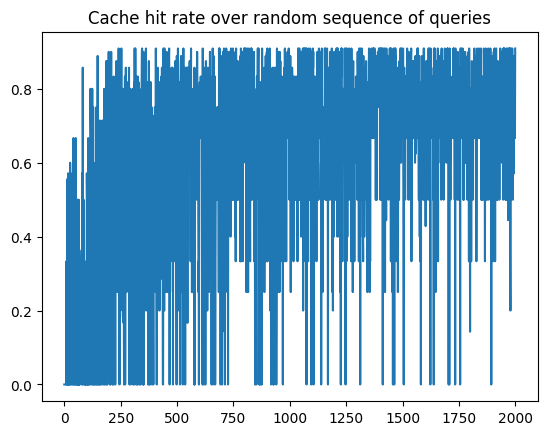

In [60]:
plt.plot(cache_status)
plt.title("Cache hit rate over random sequence of queries")
plt.show()

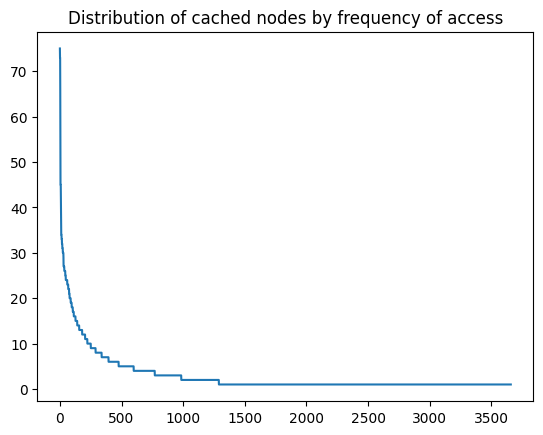

In [61]:
plt.plot(sorted(cache_state.values(), reverse=True))
plt.title("Distribution of cached nodes by frequency of access")
plt.show()

In [62]:
len(cache_state)

3659

In [63]:
from pyvis.network import Network

g = index.get_networkx_graph()
net = Network(notebook=True, cdn_resources="in_line", directed=True)
net.from_nx(g)
net.show('example.html')
print('done')

example.html
done


In [64]:
from transformers import pipeline

triplet_extractor = pipeline(
    "text2text-generation",
    model="Babelscape/rebel-large",
    tokenizer="Babelscape/rebel-large",
    # comment this line to run on CPU
    device="cuda:0",
)


def extract_triplets(input_text):
    text = triplet_extractor.tokenizer.batch_decode(
        [
            triplet_extractor(
                input_text, return_tensors=True, return_text=False
            )[0]["generated_token_ids"]
        ]
    )[0]

    triplets = []
    relation, subject, relation, object_ = "", "", "", ""
    text = text.strip()
    current = "x"
    for token in (
        text.replace("<s>", "")
        .replace("<pad>", "")
        .replace("</s>", "")
        .split()
    ):
        if token == "<triplet>":
            current = "t"
            if relation != "":
                triplets.append(
                    (subject.strip(), relation.strip(), object_.strip())
                )
                relation = ""
            subject = ""
        elif token == "<subj>":
            current = "s"
            if relation != "":
                triplets.append(
                    (subject.strip(), relation.strip(), object_.strip())
                )
            object_ = ""
        elif token == "<obj>":
            current = "o"
            relation = ""
        else:
            if current == "t":
                subject += " " + token
            elif current == "s":
                object_ += " " + token
            elif current == "o":
                relation += " " + token

    if subject != "" and relation != "" and object_ != "":
        triplets.append((subject.strip(), relation.strip(), object_.strip()))

    return triplets

In [10]:
index = KnowledgeGraphIndex.from_documents(
    documents,
    max_triplets_per_chunk=20,
    kg_triplet_extract_fn=extract_triplets,
    storage_context=storage_context,
    include_embeddings=True,
    show_progress=True,
)

Processing nodes:   0%|          | 10/2060 [00:04<18:15,  1.87it/s]/var/home/zaristei/.conda/envs/rag-project/lib/python3.11/site-packages/transformers/pipelines/base.py:1157: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Processing nodes: 100%|██████████| 2060/2060 [17:15<00:00,  1.99it/s]


In [11]:
from pyvis.network import Network

g = index.get_networkx_graph()
net = Network(notebook=True, cdn_resources="in_line", directed=True)
net.from_nx(g)
net.show('example.html')
print('done')

example.html
done


In [18]:
import wikipedia


class WikiFilter:
    def __init__(self):
        self.cache = {}
        self.neg_cache = set()

    def filter(self, candidate_entity):
        # check the cache to avoid network calls
        if candidate_entity in self.cache:
            return self.cache[candidate_entity]["title"]
        elif candidate_entity in self.neg_cache:
            return None

        # pull the page from wikipedia -- if it exists
        try:
            page = wikipedia.page(candidate_entity, auto_suggest=False)
            entity_data = {
                "title": page.title,
                "url": page.url,
                "summary": page.summary,
            }

            # cache the page title and original entity
            self.cache[candidate_entity] = entity_data
            self.cache[page.title] = entity_data

            return entity_data["title"]
        except:
            self.neg_cache.add(candidate_entity)
            return None


wiki_filter = WikiFilter()


def extract_triplets_wiki(text):
    relations = extract_triplets(text)

    filtered_relations = []
    for relation in relations:
        (subj, rel, obj) = relation
        filtered_subj = wiki_filter.filter(subj)
        filtered_obj = wiki_filter.filter(obj)

        # skip if at least one entity not linked to wiki
        if filtered_subj is None and filtered_obj is None:
            continue

        filtered_relations.append(
            (
                filtered_subj or subj,
                rel,
                filtered_obj or obj,
            )
        )

    return filtered_relations

In [19]:
documents = [Document(text="\n\n\n".join([doc.text for doc in documents]))]

In [20]:
index = KnowledgeGraphIndex.from_documents(
    documents,
    max_triplets_per_chunk=20,
    kg_triplet_extract_fn=extract_triplets_wiki,
    storage_context=storage_context,
    include_embeddings=True,
    show_progress=True,
)

Processing nodes:   0%|          | 0/1000 [00:00<?, ?it/s]/var/home/zaristei/.conda/envs/rag-project/lib/python3.11/site-packages/transformers/pipelines/base.py:1157: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Processing nodes:   0%|          | 2/1000 [00:03<26:28,  1.59s/it]/var/home/zaristei/.conda/envs/rag-project/lib/python3.11/site-packages/wikipedia/wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("html.parser"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file /var/home/zaristei/.conda/envs/rag-project/lib/python3.11/site-packages/wikipedia/wikipedia.py. To get rid of this warning, pass the additional argument 'features

In [12]:
index.get_networkx_graph().number_of_nodes()

70

In [14]:
from pyvis.network import Network

g = index.get_networkx_graph()
net = Network(notebook=True, cdn_resources="in_line", directed=True)
net.from_nx(g)
net.show('example.html')
print('done')

example.html
done
